# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Bussiness Understanding

The dataset seems to belong to some digial music streaming Platform. Whenever a user interacts with the music streaming service the logs get generated like timestamp and the ahe activity page(i.e logOut, like, logIn etc). Tthere are basically types of user 1. free -tier and 2. subscription based. so based on the activity of the user we need to figure out which user is likely to churn out. So that, some kind of discounts can be rolled out to that specific users.

# Data Understanding

the datat is contained in a file `mini_sparkify_event_data.json` 
Data description :
* artist: string name of artist
* auth : String authencation levels
* firstName: string first name of user
* gender: string Gender of user
* itemInSession: long log count in the session
* lastName: string last name of the user
* length: double length of the song
* level: string type of subscription
* location: string location of user
* method: string tupe of request
* page: string type of interaction
* registration: long registration timestamp
* sessionId: long session id of the user
* song: string name of song
* status: long http status code
* ts: long timestamp
* userAgent: string agent used by user for straeming service
* userId: string inique identifier of  the user


In [137]:
# import libraries
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list,dayofmonth
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as f
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
import pandas as pd
%matplotlib inline
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

C:\Users\PRAVEEN KUMAR\Anaconda3\envs\pyspark_env\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [3]:
# create a Spark session
sc =  SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [21]:
# Read dataset
filename = 'mini_sparkify_event_data.json'
df = sc.read.json(filename)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [311]:
def show_df(df):
    """
        ARGS:
            - spark Dataframe
        RETURNS:
            - Prints dataframe
    """
    return pd.DataFrame(df,columns=df.columns).head()
show_df(df)

ValueError: DataFrame constructor not properly called!

In [6]:
def df_dimentions(df):
    """
        Prints number of Rows and Columns
        ARGS:
            - Dataframe
    """
    print(f"row count: {df.count()}, column count: {len(df.columns)}")
df_dimentions(df)

row count: 286500, column count: 18


In [25]:
## remove special characters from column
def remove_special_chars(df):
    """
        removes special characters from data
        ARGS:
            - Dataframe
        RETURNS:
            - clear Dataframe
    """
    for field in df.schema.fields:
        if field.dataType == StringType():
            df = df.withColumn(field.name,regexp_replace(field.name,'[^a-zA-Z0-9\,\-]',''))
    
    return df
df = remove_special_chars(df)
show_df(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,MarthaTilston,LoggedIn,Colin,M,50,Freeman,277.89016,paid,"Bakersfield,CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Firefox310,30
1,FiveIronFrenzy,LoggedIn,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton,MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML,likeGeckoChrome3702062103Safari53736",9
2,AdamLambert,LoggedIn,Colin,M,51,Freeman,282.82730,paid,"Bakersfield,CA",PUT,NextSong,1538173362000,29,TimeForMiracles,200,1538352394000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Firefox310,30
3,Enigma,LoggedIn,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton,MA-NH",PUT,NextSong,1538331630000,8,KnockingOnForbiddenDoors,200,1538352416000,"Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML,likeGeckoChrome3702062103Safari53736",9
4,DaftPunk,LoggedIn,Colin,M,52,Freeman,223.60771,paid,"Bakersfield,CA",PUT,NextSong,1538173362000,29,HarderBetterFasterStronger,200,1538352676000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Firefox310,30


In [138]:
def convert_unixtimestamp(df,ts_col):
    """
        converts unix timestamp to date time
        ARGS:
            - df: Dataframe with Unixtimestamp
            - ts: unixtimestamp column name
        RETURNS:
            - dataframe with new datetime column
    """
   
    df = df.withColumn("dateTime",from_unixtime(col(ts_col).cast(LongType())/1000).cast(TimestampType()))
    df = df.withColumn("month",month(col('dateTime')))
    df = df.withColumn("dayOfMonth",dayofmonth(col('dateTime')))
    df = df.withColumn("hour",hour(col('dateTime')))
    df = df.withColumn("date",from_unixtime(col(ts_col)/1000).cast(DateType()))
    df = df.withColumn("location",split(col('location'),',').getItem(1))
    df = df.filter(col('userId').isNotNull())
    return df


In [139]:
# create time series column
df = convert_unixtimestamp(df,'ts')

In [10]:
df.filter(col('userId').isNull()).count()

0

In [122]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')
# Check
df.filter(df.userId == '').count()

0

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [48]:
def bar_plot(df,col1,col2=None,hue=None,labels=None):
    """
        plots using the data 
        ARGS:
            - df: Pandas Dataframe
    """
    plt.figure(figsize=(15,5))
    plot = sns.barplot(data=df,x=col1,y=col2,hue=hue)
    plot.set_xticklabels(labels)
    plt.show()
    

In [15]:
def distinct_attributes(df,col_name):
    """
        Prints all the distinct attributes/values of a single column
        ARGS:
            - df: Dataframe
            - col_name: Name of the column for distinct attributes
        
    """
    print(df.select(col_name).distinct().collect())

In [ ]:
def categorical_columns(df):
    """
        prints distinct values of categorical columns
        ARGS:
            - df: Dataframe
    """
    for field in df.schema.fields:
        if ((field.dataType == StringType()) and (field.name not in ['userId','lastName','userAgent','firstName','artist','song'] )):
            print(field.name)
            distinct_attributes(df,field.name)
            print("*"*50)
categorical_columns(df)

In [ ]:
#filter pages of type CancellationConfirmation
df.filter(df.page=="CancellationConfirmation").select("userId").dropDuplicates().show(10)

In [38]:
def create_label(df):
    """
        Create label columns containing 1,0 for cancellation page and auth is cancled
        ARGS:
            - df: Dataframe 
        RETURNS:
            - Dataframe with labeled columns
    """
    
    flag_cancelation_event = udf(lambda x: 1 if x == "CancellationConfirmation" else 0, IntegerType())
    # apply to the dataframe
    df = df.withColumn("label", flag_cancelation_event("page"))
    #Define window bounds
    windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    # Applying the window
    df = df.withColumn("label", sum("label").over(windowval))
    return df
# Create Label as churn Column
df = create_label(df)
show_df(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,dateTime,month,hour,date,weekDay,label
0,SleepingWithSirens,LoggedIn,Darianna,F,0,Carpenter,202.97098,free,CT,PUT,NextSong,1538016340000,31,CaptainTyinKnotsVSMrWalkwayNoWay,200,1539003534000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:28:54,10,18,2018-10-08,1,0
1,FrancescaBattistelli,LoggedIn,Darianna,F,1,Carpenter,196.54485,free,CT,PUT,NextSong,1538016340000,31,BeautifulBeautifulAlbum,200,1539003736000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:32:16,10,18,2018-10-08,1,0
2,Brutha,LoggedIn,Darianna,F,2,Carpenter,263.13098,free,CT,PUT,NextSong,1538016340000,31,ShesGone,200,1539003932000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:35:32,10,18,2018-10-08,1,0
3,None,LoggedIn,Darianna,F,3,Carpenter,NaN,free,CT,PUT,ThumbsUp,1538016340000,31,None,307,1539003933000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:35:33,10,18,2018-10-08,1,0
4,JoshRitter,LoggedIn,Darianna,F,4,Carpenter,316.23791,free,CT,PUT,NextSong,1538016340000,31,FolkBloodbath,200,1539004195000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:39:55,10,18,2018-10-08,1,0


In [39]:
show_df(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,dateTime,month,hour,date,weekDay,label
0,SleepingWithSirens,LoggedIn,Darianna,F,0,Carpenter,202.97098,free,CT,PUT,NextSong,1538016340000,31,CaptainTyinKnotsVSMrWalkwayNoWay,200,1539003534000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:28:54,10,18,2018-10-08,1,0
1,FrancescaBattistelli,LoggedIn,Darianna,F,1,Carpenter,196.54485,free,CT,PUT,NextSong,1538016340000,31,BeautifulBeautifulAlbum,200,1539003736000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:32:16,10,18,2018-10-08,1,0
2,Brutha,LoggedIn,Darianna,F,2,Carpenter,263.13098,free,CT,PUT,NextSong,1538016340000,31,ShesGone,200,1539003932000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:35:32,10,18,2018-10-08,1,0
3,None,LoggedIn,Darianna,F,3,Carpenter,NaN,free,CT,PUT,ThumbsUp,1538016340000,31,None,307,1539003933000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:35:33,10,18,2018-10-08,1,0
4,JoshRitter,LoggedIn,Darianna,F,4,Carpenter,316.23791,free,CT,PUT,NextSong,1538016340000,31,FolkBloodbath,200,1539004195000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:39:55,10,18,2018-10-08,1,0


In [40]:
# Number of users in Dataset
df.select('userId').dropDuplicates().count()

226

In [44]:
# create dataframe for plotting count of different labels of all the users
label_df = df.dropDuplicates(['userId']).groupby(['label']).count()
label_df = label_df.toPandas()

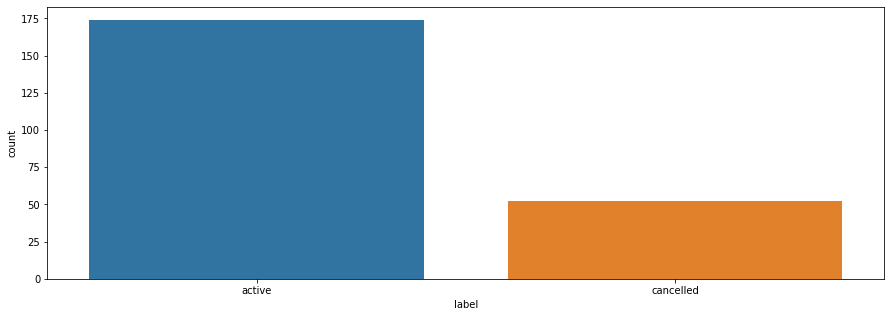

In [49]:
# the data set is highly imbalanced
bar_plot(label_df,'label','count',labels=['active','cancelled'])

In [18]:
df.head()

Row(artist='SleepingWithSirens', auth='LoggedIn', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='CaptainTyinKnotsVSMrWalkwayNoWay', status=200, ts=1539003534000, userAgent='Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753', userId='100010', dateTime=datetime.datetime(2018, 10, 8, 18, 28, 54), month=10, date=datetime.date(2018, 10, 8), label=0)

In [51]:
# types of user churn by gender
gender_df = df.dropDuplicates(['userId', 'gender']).groupby(['label', 'gender']).count()
gender_df = gender_df.toPandas()

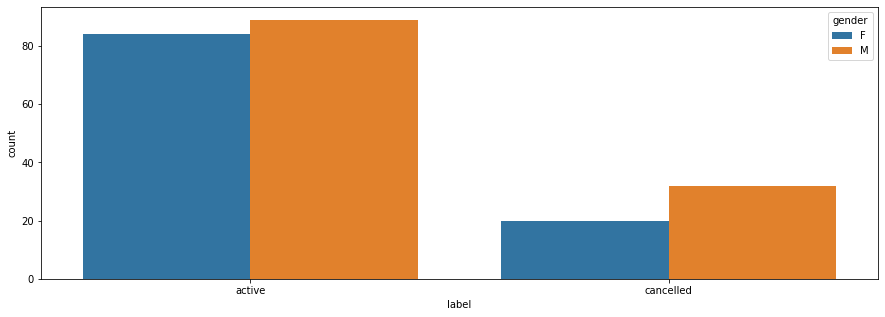

In [56]:
bar_plot(gender_df,'label','count','gender',labels=['active','cancelled'])

In [53]:
# User status by paid level
paid_df = df.dropDuplicates(['userId', 'level']).groupby(['label', 'level']).count()
paid_df = paid_df.toPandas()

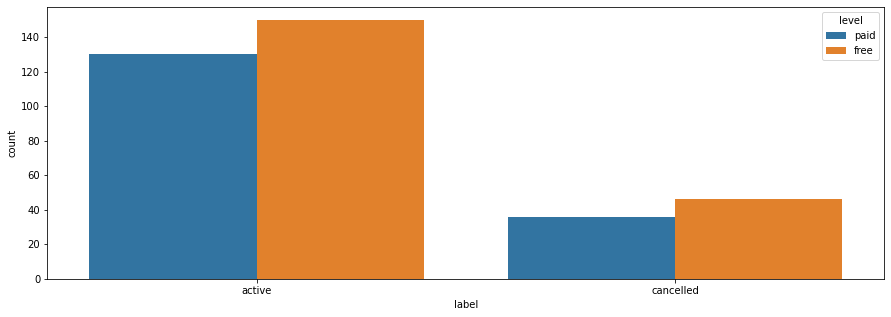

In [54]:
bar_plot(paid_df,'label','count','level',labels=['active','cancelled'])

In [89]:
# count of user location wise 
location_df = df.dropDuplicates().groupBy(['location']).agg(count('location').alias('count'))
location_df = location_df.toPandas()
location_df.head()

,location,count
0,UT-ID,317
1,AZ,4846
2,SC,668
3,GA-AL,2716
4,LA,1171


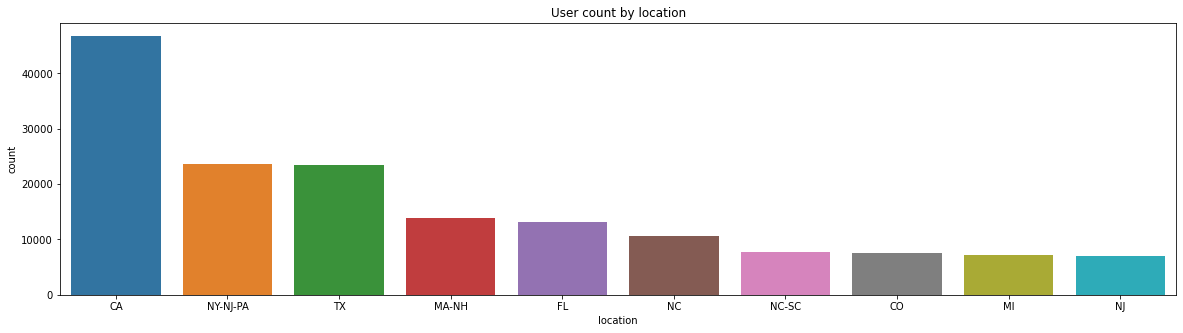

In [111]:
#plot to 10 location
plt.figure(figsize=(20,5))
sns.barplot(data=location_df.sort_values(by='count',ascending=False).head(10),x='location',y='count')
plt.title('User count by location')
plt.show()

CA , NY, TX, MA, FL, NC has top 5 locations based on user

In [59]:
active_df = df.drop_duplicates().groupby(['auth']).agg(count('auth').alias('count'))
active_df = active_df.toPandas()

,auth,count
0,Cancelled,52
1,Guest,97
2,LoggedIn,278102
3,LoggedOut,8249


count based on type of auth


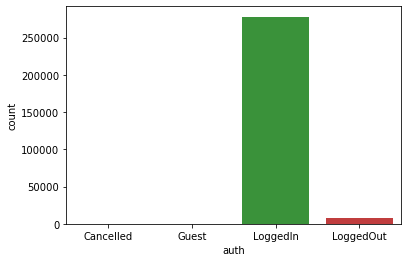

In [135]:
sns.barplot(x='auth',y='count',data=active_df)
print('count based on type of auth')

very few uers cancelled

In [105]:
# user by  page
user_page_df = df.groupBy(['page']).agg(count('userId').alias('userCount')).drop('NextSong')
user_page_df = user_page_df.toPandas().sort_values(by='userCount',ascending=False) 
user_page_df                       

,page,userCount
11,NextSong,228108
5,ThumbsUp,12551
3,Home,10082
13,AddtoPlaylist,6526
18,AddFriend,4277
12,RollAdvert,3933
7,Logout,3226
2,ThumbsDown,2546
4,Downgrade,2055
9,Settings,1514


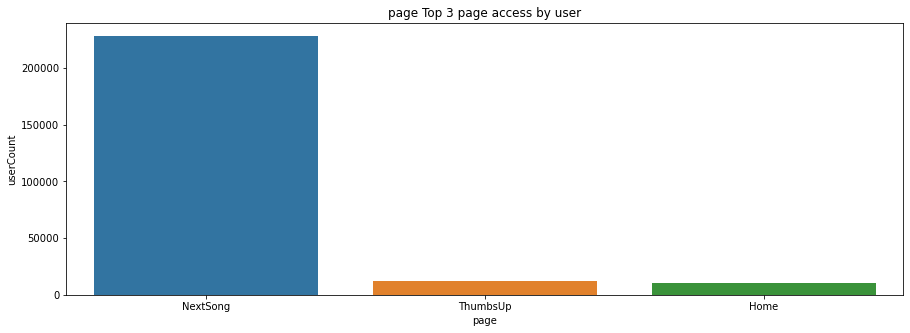

In [110]:
plt.figure(figsize=(15,5))
sns.barplot(x='page',y='userCount',data=user_page_df.head(3))
plt.title('page Top 3 page access by user')
plt.show()

NestSong ws the most used page which is quite obvious in music streaming app

In [87]:
def count_missings(spark_df,sort=True):
    """
        Counts number of nulls and nans in each column
        ARGS:
            - spark_df: RDD dataframe 
    """
    df = spark_df.select([f.count(f.when(f.isnan(c) | f.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'missing_value_count'}).T.sort_values("missing_value_count",ascending=False)

    return df

In [88]:
count_missings(df)

,missing_value_count
length,50046
itemInSession,0
registration,0
sessionId,0
status,0
ts,0
month,0
label,0


In [ ]:
def plot_spark_df(df,col_name):
    """
        Plots histogram for from spark dataframe
        ARGS:
            - df: Spark dataframe
    """
    pd_df = df.toPandas()
    plt.figure(figsize=(15,5))
    sns.barplot(x=col_name,data=pd_df)

In [ ]:
pd_df = df.toPandas()
sns.barplot(x='auth',data=pd_df)

## Timeline Analysis

In [136]:
# defining udf to get weekday
# reference: https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark

funcWeekDay =  udf(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%w'))     

df = df.withColumn('shortdate',col('dateTime').substr(1, 10))\
     .withColumn('weekDay', funcWeekDay(col('shortdate')))\
     .drop('shortdate')
show_df(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,dateTime,month,hour,date,weekDay,label
0,SleepingWithSirens,LoggedIn,Darianna,F,0,Carpenter,202.97098,free,CT,PUT,NextSong,1538016340000,31,CaptainTyinKnotsVSMrWalkwayNoWay,200,1539003534000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:28:54,10,18,2018-10-08,1,0
1,FrancescaBattistelli,LoggedIn,Darianna,F,1,Carpenter,196.54485,free,CT,PUT,NextSong,1538016340000,31,BeautifulBeautifulAlbum,200,1539003736000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:32:16,10,18,2018-10-08,1,0
2,Brutha,LoggedIn,Darianna,F,2,Carpenter,263.13098,free,CT,PUT,NextSong,1538016340000,31,ShesGone,200,1539003932000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:35:32,10,18,2018-10-08,1,0
3,None,LoggedIn,Darianna,F,3,Carpenter,NaN,free,CT,PUT,ThumbsUp,1538016340000,31,None,307,1539003933000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:35:33,10,18,2018-10-08,1,0
4,JoshRitter,LoggedIn,Darianna,F,4,Carpenter,316.23791,free,CT,PUT,NextSong,1538016340000,31,FolkBloodbath,200,1539004195000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",100010,2018-10-08 18:39:55,10,18,2018-10-08,1,0


In [105]:
month1_user_df = df.filter(col('label') == 1).groupby(col('month')).agg(count(col('userId')).alias('churnedUserCount'))
month2_user_df = df.filter(col('label') == 0).groupby(col('month')).agg(count(col('userId')).alias('unChurnedUserCount'))
month_churn_df = month1_user_df.join(month2_user_df,on='month',how='full').fillna(0).toPandas().melt(id_vars='month')

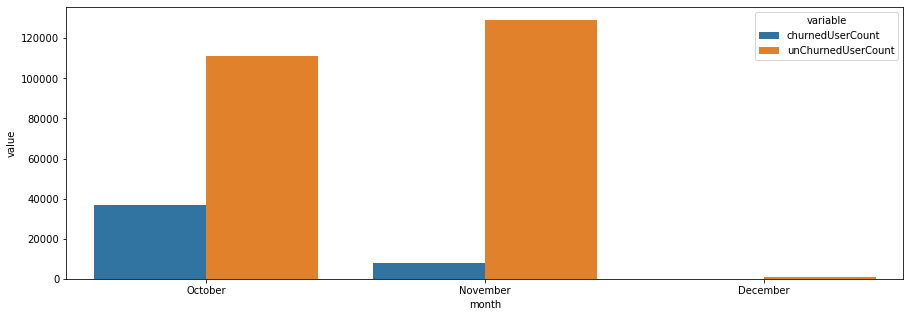

In [114]:
seab = bar_plot(month_churn_df,col2='value',col1='month',hue='variable',labels=['October','November','December'])

churn count is high in October but reduced in November

In [148]:
weekday_gender_df = df.groupby('weekDay','gender').agg(count('userId').alias('userCount'))
weekday_gender_df = weekday_gender_df.toPandas()
weekday_gender_df

,weekDay,gender,userCount
0,0,M,9411
1,4,F,23811
2,1,M,17570
3,3,M,20360
4,6,F,18303
5,2,F,25374
6,0,F,13091
7,2,M,20553
8,6,M,14651
9,1,F,18530


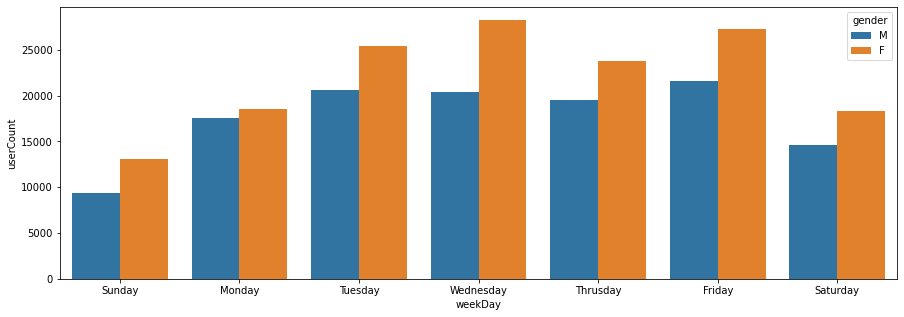

                                        daywise churn count of user comparison male vs Female


In [149]:
labels = ['Sunday','Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday']
bar_plot(weekday_gender_df,col1='weekDay',col2='userCount',hue='gender',labels=labels)
print(" "*40+'daywise churn count of user comparison male vs Female')

churn rate is low on Sunday and Saturday, Females have high Churn rate

In [152]:
day_and_gender_df = df.groupby('gender','dayOfMonth').agg(count('userId').alias('userCount'))
day_and_gender_df = day_and_gender_df.toPandas()

TypeError: 'NoneType' object is not iterable

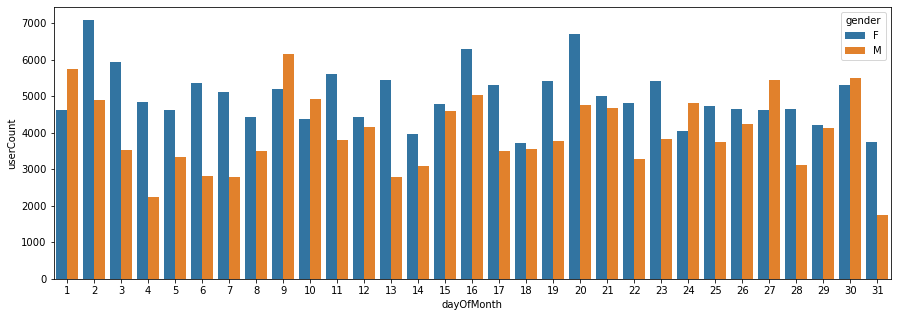

In [153]:
bar_plot(day_and_gender_df,col1='dayOfMonth',hue='gender',col2='userCount')

Churn count is high in the Females for starting days of month. 1st of the month the churn count is high in male. since the dataset contains few months of data concrete results can be drawn. 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [155]:
# lets investigate the type of os used by user to access the Song streaming platform
# Nuber of unique platforms
dfp.userAgent.unique().shape[0]

57

In [190]:
test_str = 'Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753'
reg

In [258]:
import re
reg = re.compile('[^Mozilla50+]+[a-zA-Z]+')
reg.search(test_str)

<_sre.SRE_Match object; span=(10, 26), match='PhoneCPUiPhoneOS'>

In [260]:
# calulate the duration a user spends on Music streaming App
def calculate_active_duration(df):
    """
        Calculates number of days a user is active since the day he registerd
        ARGS:
            - dataframe
        REURNS:
            - Dataframe with new colum activeDuration
    """
    df = df.withColumn('regDatetime',from_unixtime(col('registration')/1000).cast(DateType()))
    user_duration_df = df.groupBy('UserId','regDatetime').agg(max('date').alias('lastInterationDate')) 
    diff  = (f.unix_timestamp('lastInterationDate')-f.unix_timestamp('regDatetime'))
    duration_df = user_duration_df.withColumn('activeDuration',diff/86400)
    
    df = df.join(duration_df,on='UserId')
    return df  

In [157]:
df = calculate_active_duration(df)
show_df(df)

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,dateTime,month,hour,date,weekDay,label,dayOfMonth,regDatetime,regDatetime,lastInterationDate,activeDuration
0,100010,SleepingWithSirens,LoggedIn,Darianna,F,0,Carpenter,202.97098,free,None,PUT,NextSong,1538016340000,31,CaptainTyinKnotsVSMrWalkwayNoWay,200,1539003534000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",2018-10-08 18:28:54,10,18,2018-10-08,1,0,8,2018-09-27,2018-09-27,2018-11-21,55.0
1,100010,FrancescaBattistelli,LoggedIn,Darianna,F,1,Carpenter,196.54485,free,None,PUT,NextSong,1538016340000,31,BeautifulBeautifulAlbum,200,1539003736000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",2018-10-08 18:32:16,10,18,2018-10-08,1,0,8,2018-09-27,2018-09-27,2018-11-21,55.0
2,100010,Brutha,LoggedIn,Darianna,F,2,Carpenter,263.13098,free,None,PUT,NextSong,1538016340000,31,ShesGone,200,1539003932000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",2018-10-08 18:35:32,10,18,2018-10-08,1,0,8,2018-09-27,2018-09-27,2018-11-21,55.0
3,100010,None,LoggedIn,Darianna,F,3,Carpenter,NaN,free,None,PUT,ThumbsUp,1538016340000,31,None,307,1539003933000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",2018-10-08 18:35:33,10,18,2018-10-08,1,0,8,2018-09-27,2018-09-27,2018-11-21,55.0
4,100010,JoshRitter,LoggedIn,Darianna,F,4,Carpenter,316.23791,free,None,PUT,NextSong,1538016340000,31,FolkBloodbath,200,1539004195000,"Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753",2018-10-08 18:39:55,10,18,2018-10-08,1,0,8,2018-09-27,2018-09-27,2018-11-21,55.0


In [259]:
def user_session_sum():
    """
        Create a column containing the sum of ItemInSession column
        RETURNS:
            - Dataframe containing column sumItemInSession 
    """
    item_sum_df = df.groupby('userId').agg(sum(col('itemInSession')).alias('sumItemInSession'))
    df =  df.join(item_sum_df,on='userId')
    return df

In [285]:
def user_stats(df):
    """
        Calculate Song length per user per session 
        ARGS:
            - df: SparkDataframe
        RETURNS:
            - Spark Dataframe with meanHours and stdevHours
    """
    song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
    song_length = song_length.withColumn('hours', (song_length.length / 3600))
    song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
    song_length = song_length.groupBy('userId').agg(
                        avg('sum(hours)').alias('meanHours'), 
                        stddev('sum(hours)').alias('stdevHours')).na.fill(0)
    
    return song_length

In [278]:
def songs_per_session(df):
    """
        number of changing songs
        ARGS:
            - df: Sparkdataframe
        RETURNS:
            - pandas dataframe with columns meanSongs, stdevSongs
    """
    song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
    song_user_df = song_user_df.groupBy('userId').agg(
                        avg('count').alias('meanSongs'), 
                        stddev('count').alias('stdevSongs'))
    song_user_df = song_user_df.na.fill(0)
    
    return song_user_df


In [280]:
def artists_per_user(df):
    """
        creates the number of artists the user liked
        ARGS:
            - df: Spark dataframe
        RETURNS:
            - Pandas dataframe with artistLiked
    """
    artists_user_df = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "artistLiked")
    
    return artists_user_df

In [304]:
def session_stats(df):
    """
        creates mean and stdev for session of each user
        ARGS:
            - df: Dataframe
        RESULTS:
            - Spark Dataframe with columns for
    """
    session_user_df = df.groupBy('userId').agg(
                        avg('activeDuration').alias('meanSession'), 
                        stddev('activeDuration').alias('stdevSession'))

    session_user_df = session_user_df.na.fill(0)
    return session_user_df

## Join all features


In [306]:
user_stats_df = user_stats(df)
artists_per_user_df = artists_per_user(df)
songs_per_session_df = songs_per_session(df)
session_stats_df = session_stats(df)

In [307]:
def join_dataframe(base,new_df):
    """
        Joins new dataframe to base dataframe
        ARGS: 
            - base: Sparkdataframe
        RETURNS:
            - new_df: newly created dataframe to megre with base data frame
    """
    base_df = base.join(new_df,on='userId',how='inner')
    return base_df

In [ ]:
feature_list_df = [user_stats_df,artists_per_user_df,songs_per_session_df,session_stats_df]
def create_final_dataset(feature_list_df):
    """
        Merges all the features to one final Spark dataframe            
    """
    print('Dimentions before joining')
    df_dimentions(df)
    for i,feature in enumerate(feature_list_df):
        feature_df = join_dataframe(df,feature)
        print("Newly added features: ",[x for x in feature.columns if x not in ['userId']])
    print('Dimentions after joining')
    df_dimentions(df)    
create_final_dataset(feature_list_df)

Dimentions before joining
row count: 278154, column count: 29
Newly added features:  ['meanHours', 'stdevHours']
Newly added features:  ['artistLiked']
Newly added features:  ['meanSongs', 'stdevSongs']
Newly added features:  ['meanSession', 'stdevSession']
Dimentions after joining


In [310]:
final_df = feature_df.toPandas()

In [301]:
final_df.to_csv('final_dataset.CSV', index=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.